In [20]:
# Code and Programming by Mojtaba Valipour @ Shiraz University 
# 2017-2018 - www.vpcom.ir
# REF:
'''
6- http://vladlen.info/papers/carla.pdf
7- http://vladlen.info/papers/conditional-imitation.pdf 
'''
print("Copyright is important @ 2017")

Copyright is important @ 2017


In [21]:
import sys
sys.version
sys.version_info

sys.version_info(major=2, minor=7, micro=14, releaselevel='final', serial=0)

In [22]:
import tensorflow as tf 
import keras
print(tf.__version__)
print(keras.__version__)

1.4.1
2.1.2


# Config

In [23]:
timeNumberFrames = 1 #4 # number of frames in each samples
batchSize = 120 # size of batch
valBatchSize = 120 # size of batch for validation set
NseqVal = 5  # number of sequences to use for validation
# training parameters
epochs = 100
samplesPerEpoch = 500
L2NormConst = 0.001 
trainScratch = True

# Configurations
num_images = 657800 # 200 * 3289
memory_fraction=0.25
image_cut=[115, 510]
dropoutVec = [1.0] * 8 + [0.7] * 2 + [0.5] * 2 + [0.5] * 1 + [0.5, 1.] * 5
prefSize = _image_size = (88, 200, 3)
#batchSize = 120
learningRate = 0.0002 # multiplied by 0.5 every 50000 mini batch
iterNum = 294000
beta1 = 0.7
beta2 = 0.85
controlInputs = [2,5,3,4] # Control signal, int ( 2 Follow lane, 3 Left, 4 Right, 5 Straight)
cBranchesOutList = ['Follow Lane','Go Left','Go Right','Go Straight','Speed Prediction Branch'] 

controlInputs = [2,5,3,4]
branchConfig = [["Steer", "Gas", "Brake"], ["Steer", "Gas", "Brake"], \
                     ["Steer", "Gas", "Brake"], ["Steer", "Gas", "Brake"], ["Speed"]]
params = [trainScratch, dropoutVec, image_cut, learningRate, beta1, beta2, num_images, iterNum, batchSize, valBatchSize, NseqVal, epochs, samplesPerEpoch, L2NormConst]

# GPU configuration
config = tf.ConfigProto(allow_soft_placement = True)
config.gpu_options.visible_device_list = '0'
config.gpu_options.per_process_gpu_memory_fraction = memory_fraction

# Helper Functions

In [24]:
# vpcom Special function for visualization
def plotSpecialTool(data,labels,samples2Visualize=12,factors=[2,6], grayFlag=False, figSize=(12,3), fontsize = 7):
    # samples2Visualize = 12 # sample 12 random number
    # factors = [2,6] # indicate two factors for number of samples
    assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
    figure = plt.figure(figsize=figSize)
    nLimit = data.shape[0]
    for i in range(1,samples2Visualize+1):
        img = figure.add_subplot(factors[0],factors[1],i)
        # randomly sample an image from train set
        imgID = np.random.randint(nLimit-1)
        image = data[imgID]
        if grayFlag:
            plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=plt.get_cmap('gray'))
        else:
            plt.imshow(image)
        img.set_title(["{:06.4f}".format(x) for x in labels[imgID]],fontsize=fontsize)
        plt.axis('off')

# Load Datasets

## Carla Dataset

In [25]:
# read an example h5 file
datasetDirTrain = './dataset/carla/SeqTrain/'
datasetDirVal = './dataset/carla/SeqVal/'

import glob
datasetFilesTrain = glob.glob(datasetDirTrain+'*.h5')
datasetFilesVal = glob.glob(datasetDirVal+'*.h5')

(3288, './dataset/carla/SeqTrain/data_03663.h5', 374)
<HDF5 file "data_04866.h5" (mode r)>
[u'rgb', u'targets']
(200, 88, 200, 3)
(200, 28)


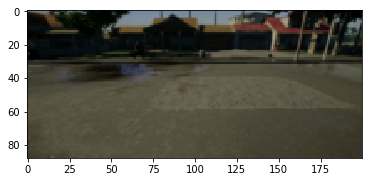

In [26]:
# understanding dataset
print(len(datasetFilesTrain), datasetFilesTrain[0], len(datasetFilesVal))

import h5py
dataset = h5py.File(datasetFilesTrain[120], 'r')


print(dataset)
print(dataset.keys())

print(dataset['rgb'].shape)

print(dataset['targets'].shape)

ind = 22

x = dataset['rgb'][ind]
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x)

tgtNameList = ['Steer', 'Gas', 'Brake', 'Hand Brake,' 'Reverse Gear', 'Steer Noise', 'Gas Noise', 'Brake Noise', 'Position X', 'Position Y', 'Speed', 'Collision Other', 'Collision Pedestrian', 'Collision Car', 'Opposite Lane Inter', 'Sidewalk Intersect', 'Acceleration X','Acceleration Y', 'Acceleration Z', 'Platform time', 'Game Time', 'Orientation X', 'Orientation Y', 'Orientation Z', 'Control signal', 'Noise', 'Camera']
dataset.close()

## Generators

In [27]:
import itertools

def genData(fileNames = datasetFilesTrain, batchSize = 200):
    #fileNames = datasetFilesTrain
    #branchNum = 3 # Control signal, int ( 2 Follow lane, 3 Left, 4 Right, 5 Straight)
    #batchSize = 200 
    batchX = np.zeros((batchSize, 88, 200, 3))    
    batchY = np.zeros((batchSize, 28))
    idx = 0       
    while True: # to make sure we never reach the end
        counter = 0
        while counter<=batchSize-1:
            idx = np.random.randint(len(fileNames)-1) 
            try:
                data = h5py.File(fileNames[idx], 'r')
            except: 
                print(idx, fileNames[idx])
            
            dataIdx = np.random.randint(200-1) 
            batchX[counter] = data['rgb'][dataIdx]
            batchY[counter] = data['targets'][dataIdx]
            counter += 1
            data.close()
        yield (batchX, batchY)

def genBranch(fileNames = datasetFilesTrain, branchNum = 3, batchSize = 200):
    #fileNames = datasetFilesTrain
    #branchNum = 3 # Control signal, int ( 2 Follow lane, 3 Left, 4 Right, 5 Straight)
    #batchSize = 200 
    batchX = np.zeros((batchSize, 88, 200, 3))    
    batchY = np.zeros((batchSize, 28))
    idx = 0       
    while True: # to make sure we never reach the end
        counter = 0
        while counter<=batchSize-1:
            idx = np.random.randint(len(fileNames)-1) 
            try:
                data = h5py.File(fileNames[idx], 'r')
            except: 
                print(idx, fileNames[idx])
            
            dataIdx = np.random.randint(200-1) 
            if data['targets'][dataIdx][24] == branchNum:
                batchX[counter] = data['rgb'][dataIdx]
                batchY[counter] = data['targets'][dataIdx]
                counter += 1
                data.close()
        yield (batchX, batchY)

# Data Augmentation

In [28]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

st = lambda aug: iaa.Sometimes(0.4, aug)
oc = lambda aug: iaa.Sometimes(0.3, aug)
rl = lambda aug: iaa.Sometimes(0.09, aug)
seq = iaa.Sequential([
        rl(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 1.5
        rl(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5)), # add gaussian noise to images
        oc(iaa.Dropout((0.0, 0.10), per_channel=0.5)), # randomly remove up to X% of the pixels
        oc(iaa.CoarseDropout((0.0, 0.10), size_percent=(0.08, 0.2),per_channel=0.5)), # randomly remove up to X% of the pixels
        oc(iaa.Add((-40, 40), per_channel=0.5)), # change brightness of images (by -X to Y of original value)
        st(iaa.Multiply((0.10, 2.5), per_channel=0.2)), # change brightness of images (X-Y% of original value)
        rl(iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5)), # improve or worsen the contrast
        #rl(iaa.Grayscale((0.0, 1))), # put grayscale
], random_order=True)

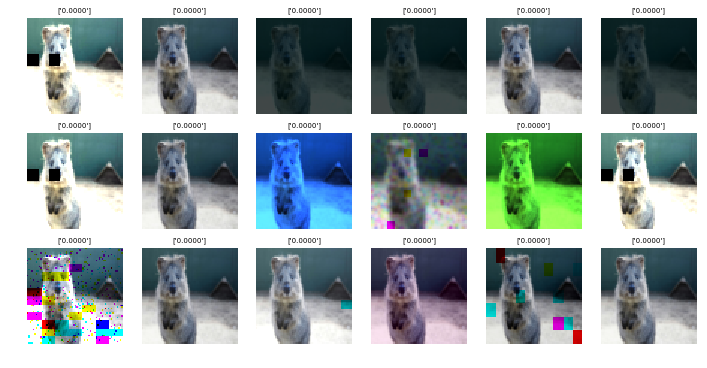

In [29]:
# Test augmentors
ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

images_aug = seq.augment_images(images)
images_aug.shape

plotSpecialTool(images_aug,np.zeros([len(images_aug),1]),samples2Visualize=18,factors=[3,6],figSize=(12,6),grayFlag=False) 

## Model Definition

In [33]:
# source: https://github.com/carla-simulator/imitation-learning
import numpy as np

import tensorflow as tf


def weight_ones(shape, name):
    initial = tf.constant(1.0, shape=shape, name=name)
    return tf.Variable(initial)


def weight_xavi_init(shape, name):
    initial = tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())
    return initial


def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape, name=name)
    return tf.Variable(initial)


class Network(object):

    def __init__(self, dropout, image_shape):
        """ We put a few counters to see how many times we called each function """
        self._dropout_vec = dropout
        self._image_shape = image_shape
        self._count_conv = 0
        self._count_pool = 0
        self._count_bn = 0
        self._count_activations = 0
        self._count_dropouts = 0
        self._count_fc = 0
        self._count_lstm = 0
        self._count_soft_max = 0
        self._conv_kernels = []
        self._conv_strides = []
        self._weights = {}
        self._features = {}

    """ Our conv is currently using bias """

    def conv(self, x, kernel_size, stride, output_size, padding_in='SAME'):
        self._count_conv += 1

        filters_in = x.get_shape()[-1]
        shape = [kernel_size, kernel_size, filters_in, output_size]

        weights = weight_xavi_init(shape, 'W_c_' + str(self._count_conv))
        bias = bias_variable([output_size], name='B_c_' + str(self._count_conv))

        self._weights['W_conv' + str(self._count_conv)] = weights
        self._conv_kernels.append(kernel_size)
        self._conv_strides.append(stride)

        conv_res = tf.add(tf.nn.conv2d(x, weights, [1, stride, stride, 1], padding=padding_in,
                                       name='conv2d_' + str(self._count_conv)), bias,
                          name='add_' + str(self._count_conv))

        self._features['conv_block' + str(self._count_conv - 1)] = conv_res

        return conv_res

    def max_pool(self, x, ksize=3, stride=2):
        self._count_pool += 1
        return tf.nn.max_pool(x, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                              padding='SAME', name='max_pool' + str(self._count_pool))

    def bn(self, x):
        self._count_bn += 1
        return tf.contrib.layers.batch_norm(x, is_training=False,
                                            updates_collections=None, scope='bn' + str(self._count_bn))

    def activation(self, x):
        self._count_activations += 1
        return tf.nn.relu(x, name='relu' + str(self._count_activations))

    def dropout(self, x):
        print "Dropout", self._count_dropouts
        self._count_dropouts += 1
        output = tf.nn.dropout(x, self._dropout_vec[self._count_dropouts - 1],
                               name='dropout' + str(self._count_dropouts))

        return output

    def fc(self, x, output_size):
        self._count_fc += 1
        filters_in = x.get_shape()[-1]
        shape = [filters_in, output_size]

        weights = weight_xavi_init(shape, 'W_f_' + str(self._count_fc))
        bias = bias_variable([output_size], name='B_f_' + str(self._count_fc))

        return tf.nn.xw_plus_b(x, weights, bias, name='fc_' + str(self._count_fc))

    def conv_block(self, x, kernel_size, stride, output_size, padding_in='SAME'):
        print " === Conv", self._count_conv, "  :  ", kernel_size, stride, output_size
        with tf.name_scope("conv_block" + str(self._count_conv)):
            x = self.conv(x, kernel_size, stride, output_size, padding_in=padding_in)
            x = self.bn(x)
            x = self.dropout(x)

            return self.activation(x)

    def fc_block(self, x, output_size):
        print " === FC", self._count_fc, "  :  ", output_size
        with tf.name_scope("fc" + str(self._count_fc + 1)):
            x = self.fc(x, output_size)
            x = self.dropout(x)
            self._features['fc_block' + str(self._count_fc + 1)] = x
            return self.activation(x)

    def get_weigths_dict(self):
        return self._weights

    def get_feat_tensors_dict(self):
        return self._features

In [34]:
# source: https://github.com/carla-simulator/imitation-learning
def load_imitation_learning_network(input_image, input_data, input_size, dropout):
    branches = []

    x = input_image

    network_manager = Network(dropout, tf.shape(x))

    """conv1"""  # kernel sz, stride, num feature maps
    xc = network_manager.conv_block(x, 5, 2, 32, padding_in='VALID')
    print xc
    xc = network_manager.conv_block(xc, 3, 1, 32, padding_in='VALID')
    print xc

    """conv2"""
    xc = network_manager.conv_block(xc, 3, 2, 64, padding_in='VALID')
    print xc
    xc = network_manager.conv_block(xc, 3, 1, 64, padding_in='VALID')
    print xc

    """conv3"""
    xc = network_manager.conv_block(xc, 3, 2, 128, padding_in='VALID')
    print xc
    xc = network_manager.conv_block(xc, 3, 1, 128, padding_in='VALID')
    print xc

    """conv4"""
    xc = network_manager.conv_block(xc, 3, 1, 256, padding_in='VALID')
    print xc
    xc = network_manager.conv_block(xc, 3, 1, 256, padding_in='VALID')
    print xc
    """mp3 (default values)"""

    """ reshape """
    x = tf.reshape(xc, [-1, int(np.prod(xc.get_shape()[1:]))], name='reshape')
    print x

    """ fc1 """
    x = network_manager.fc_block(x, 512)
    print x
    """ fc2 """
    x = network_manager.fc_block(x, 512)

    """Process Control"""

    """ Speed (measurements)"""
    with tf.name_scope("Speed"):
        speed = input_data[1]  # get the speed from input data
        speed = network_manager.fc_block(speed, 128)
        speed = network_manager.fc_block(speed, 128)

    """ Joint sensory """
    j = tf.concat([x, speed], 1)
    j = network_manager.fc_block(j, 512)

    """Start BRANCHING"""
    branch_config = [["Steer", "Gas", "Brake"], ["Steer", "Gas", "Brake"], \
                     ["Steer", "Gas", "Brake"], ["Steer", "Gas", "Brake"], ["Speed"]]

    for i in range(0, len(branch_config)):
        with tf.name_scope("Branch_" + str(i)):
            if branch_config[i][0] == "Speed":
                # we only use the image as input to speed prediction
                branch_output = network_manager.fc_block(x, 256)
                branch_output = network_manager.fc_block(branch_output, 256)
            else:
                branch_output = network_manager.fc_block(j, 256)
                branch_output = network_manager.fc_block(branch_output, 256)

            branches.append(network_manager.fc(branch_output, len(branch_config[i])))

        print branch_output

    return branches

In [36]:
from keras.layers import ConvLSTM2D, MaxPool3D, BatchNormalization, MaxPool2D
from tensorflow.contrib.layers import batch_norm
def controlNet(inputs, targets, shape, dropoutVec, branchConfig, params, scopeName = 'controlNET'):
    """
        Get one image/sequence of images to predict control operations for controling the vehicle
        inputs: N Batch of M images in order
        shape: [BatchSize, SeqSize, FrameHeight, FrameWeight, Channels]
        phase: placeholder for training
        scopeName: TensorFlow Scope Name to separate nets in the graph
    """
    with tf.variable_scope(scopeName) as scope:
        with tf.name_scope("Network"):
            
            networkTensor = load_imitation_learning_network(inputs[0], inputs[1],
                                                  shape[1:3], dropoutVec)
            solverList = []
            lossList = []
            trainVars = tf.trainable_variables()
            for i in range(0, len(branchConfig)):
                with tf.name_scope("Branch_" + str(i)):
                    if branchConfig[i][0] == "Speed":
                        # we only use the image as input to speed prediction
                        contLoss = tf.reduce_mean(tf.square(tf.subtract(networkTensor[-1], targets[0]))) #+ tf.add_n([tf.nn.l2_loss(v) for v in trainVars]) * L2NormConst
                        contSolver = tf.train.AdamOptimizer(learning_rate=params[3], beta1=params[4], beta2=params[5]).minimize(contLoss)
                        solverList.append(contSolver)
                        lossList.append(contLoss)
                        # create a summary to monitor cost tensor
                        tf.summary.scalar("Speed_Loss", contLoss)
                    else:
                        contLoss = tf.reduce_mean(tf.square(tf.subtract(networkTensor[i], targets[1]))) #+ tf.add_n([tf.nn.l2_loss(v) for v in trainVars]) * L2NormConst
                        contSolver = tf.train.AdamOptimizer(learning_rate=params[3], beta1=params[4], beta2=params[5]).minimize(contLoss)
                        solverList.append(contSolver)
                        lossList.append(contLoss)  
                        tf.summary.scalar("Control_Loss_Branch_"+str(i), contLoss)
        
        tensors = {
            'optimizers' : solverList,
            'losses' : lossList,
            'output' : networkTensor
        }
    return tensors

In [37]:
### Model Define

In [38]:
import tensorflow as tf
#params = [trainScratch, dropoutVec, image_cut, learningRate, beta1, beta2, num_images, iterNum, batchSize, valBatchSize, NseqVal, epochs, samplesPerEpoch, L2NormConst]
def Net(branchConfig, params, timeNumberFrames, prefSize=(128, 160, 3)):   
    shapeInput = [None, prefSize[0], prefSize[1], prefSize[2]]
    inputImages = tf.placeholder("float", shape=[None, prefSize[0], prefSize[1],
                                                                 prefSize[2]], name="input_image")
    inputData = []
    inputData.append(tf.placeholder(tf.float32,
                                           shape=[None, 4], name="input_control"))
    inputData.append(tf.placeholder(tf.float32,
                                           shape=[None, 1], name="input_speed"))
    
    inputs = [inputImages,inputData]
    dout = tf.placeholder("float", shape=[len(params[1])]) 

    targetSpeed = tf.placeholder(tf.float32, shape=[None, 1], name="target_speed")
    targetController = tf.placeholder(tf.float32, shape=[None, 3], name="target_control")
    
    targets = [targetSpeed, targetController]

    print('Building ControlNet ...')    
    controlOpTensors = controlNet(inputs, targets, shapeInput, dout, branchConfig, params, scopeName = 'controlNET')
    
    tensors = {
            'inputs' : inputs,
            'targets' : targets,
            'params' : params,
            'dropoutVec' : dout,
            'output' : controlOpTensors
        }
    return tensors # [ inputs['inputImages','inputData'], targets['targetSpeed', 'targetController'],  'params', dropoutVec', output[optimizers, losses, branchesOutputs] ]

## Buid && Train Models 

In [39]:
trainScratch = True

In [40]:
tf.reset_default_graph()
sessGraph = tf.Graph()

In [ ]:
from tensorflow.core.protobuf import saver_pb2
from IPython.display import clear_output
import time

# use many gpus
config = tf.ConfigProto(allow_soft_placement = True)

tf.reset_default_graph()
sessGraph = tf.Graph()

# Prepare data generators
batchListGenTrain = []
batchListGenVal = []
batchListName = []
for i in range(len(branchConfig)):
    with tf.name_scope("Branch_" + str(i)):
        if branchConfig[i][0] == "Speed":
            miniBatchGen = genData(fileNames = datasetFilesTrain, batchSize = batchSize)
            batchListGenTrain.append(miniBatchGen)
            miniBatchGen = genData(fileNames = datasetFilesVal, batchSize = batchSize)
            batchListGenVal.append(miniBatchGen)
        else:
            miniBatchGen = genBranch(fileNames = datasetFilesTrain, branchNum = controlInputs[i], batchSize = batchSize)
            batchListGenTrain.append(miniBatchGen)
            miniBatchGen = genBranch(fileNames = datasetFilesVal, branchNum = controlInputs[i], batchSize = batchSize)
            batchListGenVal.append(miniBatchGen)   

with sessGraph.as_default():
    sess = tf.Session(graph=sessGraph, config = config)
    with sess.as_default():
        
        # build model
        print('Building Net ...')
        netTensors = Net(branchConfig, params, timeNumberFrames, prefSize)
        print(netTensors['output'])

        print('Initialize Variables in the Graph ...')
        sess.run(tf.global_variables_initializer()) # initialize variables
        
        # merge all summaries into a single op
        merged_summary_op = tf.summary.merge_all()

        saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)
        if not(trainScratch):
            saver.restore(sess, "test/model.ckpt") # restore trained parameters

        # op to write logs to Tensorboard
        logsPath = './logs'
        modelPath = './test/'
        summary_writer = tf.summary.FileWriter(logsPath, graph=sessGraph)
        print('Start Training process ...')
        
        steps = 0
        for epoch in range(epochs):
            tStartEpoch = time.time()
            print("  Epoch:", epoch)
            for j in range(int(num_images/batchSize)):
                steps += 1
                
                for i in range(0, len(branchConfig)):

                        xs , ys = next(batchListGenTrain[i])
                        
                        # augment images
                        xs = seq.augment_images(xs)
                        
                        contSolver = netTensors['output']['optimizers'][i]#solverList[i]
                        contLoss = netTensors['output']['losses'][i]#lossList[i]

                        inputData = []
                        inputData.append(sess.run(tf.one_hot(ys[:,24],4))) # Command Control
                        inputData.append(ys[:,10].reshape([batchSize,1])) # Speed 
                        
                        # [ inputs['inputImages','inputData'], targets['targetSpeed', 'targetController'],  'params', dropoutVec', output[optimizers, losses, branchesOutputs] ]
                        feedDict = {netTensors['inputs'][0]: xs, netTensors['inputs'][1][0]: inputData[0], netTensors['inputs'][1][1]: inputData[1], netTensors['dropoutVec']: dropoutVec, netTensors['targets'][0]: ys[:,10].reshape([120,1]), netTensors['targets'][1]: ys[:,0:3]}                       
                        _,loss_value = sess.run([contSolver, contLoss], feed_dict = feedDict)
                        
                        # write logs at every iteration
                        feedDict = {netTensors['inputs'][0]: xs, netTensors['inputs'][1][0]: inputData[0], netTensors['inputs'][1][1]: inputData[1], netTensors['dropoutVec']: [1] * len(dropoutVec), netTensors['targets'][0]: ys[:,10].reshape([120,1]), netTensors['targets'][1]: ys[:,0:3]}                       
                        summary = merged_summary_op.eval(feed_dict=feedDict)
                        summary_writer.add_summary(summary, epoch * num_images/batchSize + j)

                        print("  Train::: Epoch: %d, Step: %d, TotalSteps: %d, Loss: %g" % (epoch, epoch * batchSize + j, steps, loss_value), cBranchesOutList[i])
                        
                        if steps % 10 == 0:
                            #clear_output(wait=True)netTensors
                            xs, ys = next(batchListGenVal[i])
                            contLoss = netTensors['output']['losses'][i]
                            feedDict = {netTensors['inputs'][0]: xs, netTensors['inputs'][1][0]: inputData[0], netTensors['inputs'][1][1]: inputData[1], netTensors['dropoutVec']: [1] * len(dropoutVec), netTensors['targets'][0]: ys[:,10].reshape([120,1]), netTensors['targets'][1]: ys[:,0:3]}                       
                            loss_value = contLoss.eval(feed_dict=feedDict)
                            print("  Val::: Epoch: %d, Step: %d, TotalSteps: %d, Loss: %g" % (epoch, epoch * batchSize + j, steps, loss_value), cBranchesOutList[i])
                            
                if steps % 10 == 0:
                    clear_output(wait=True)

                if steps % 50 == 0 and steps!=0: # batchSize
                    print(j%50, '  Save Checkpoint ...')
                    if not os.path.exists(modelPath):
                        os.makedirs(modelPath)
                    checkpoint_path = os.path.join(modelPath, "model.ckpt")
                    filename = saver.save(sess, checkpoint_path)
                    print("  Model saved in file: %s" % filename)

                if steps % 50000 == 0 and steps!=0: # every 50000 step, multiply learning rate by half
                    print("Half the learning rate ....")
                    solverList = []
                    lossList = []
                    trainVars = tf.trainable_variables()
                    for i in range(0, len(branchConfig)):
                        with tf.name_scope("Branch_" + str(i)):
                            if branchConfig[i][0] == "Speed":
                                # we only use the image as input to speed prediction
                                #if not (j == 0):
                                # [ inputs['inputImages','inputData'], targets['targetSpeed', 'targetController'],  'params', dropoutVec', output[optimizers, losses, branchesOutputs] ]
                                # params = [trainScratch, dropoutVec, image_cut, learningRate, beta1, beta2, num_images, iterNum, batchSize, valBatchSize, NseqVal, epochs, samplesPerEpoch, L2NormConst]                
                                params[3] = params[3] * 0.5 # update Learning Rate
                                contLoss = tf.reduce_mean(tf.square(tf.subtract(netTensors['output']['branchesOutputs'][-1], netTensors['targets'][0]))) #+ tf.add_n([tf.nn.l2_loss(v) for v in trainVars]) * L2NormConst
                                contSolver = tf.train.AdamOptimizer(learning_rate=params[3], beta1=params[4], beta2=params[5]).minimize(contLoss)
                                solverList.append(contSolver)
                                lossList.append(contLoss)
                                # create a summary to monitor cost tensor
                                tf.summary.scalar("Speed_Loss", contLoss)
                            else:
                                #if not (j == 0):
                                params[3] = params[3] * 0.5
                                contLoss = tf.reduce_mean(tf.square(tf.subtract(netTensors['output']['branchesOutputs'][i], netTensors['targets'][1]))) #+ tf.add_n([tf.nn.l2_loss(v) for v in trainVars]) * L2NormConst
                                contSolver = tf.train.AdamOptimizer(learning_rate=params[3], beta1=params[4], beta2=params[5]).minimize(contLoss)
                                solverList.append(contSolver)
                                lossList.append(contLoss)  
                                tf.summary.scalar("Control_Loss_Branch_"+str(i), contLoss)
                                
                    # update new Losses and Optimizers 
                    print('Initialize Variables in the Graph ...')
                    # merge all summaries into a single op
                    merged_summary_op = tf.summary.merge_all()
                    sess.run(tf.global_variables_initializer())
                    saver.restore(sess, "test/model.ckpt") # restore trained parameters

                if steps % 294000 == 0 and steps!=0:
                    # finish the training
                    break
            if steps % 294000 == 0 and steps!=0:
                # finish the training
                print('Finalize the training and Save Checkpoint ...')
                if not os.path.exists(modelPath):
                    os.makedirs(modelPath)
                checkpoint_path = os.path.join(modelPath, "model.ckpt")
                filename = saver.save(sess, checkpoint_path)
                print("  Model saved in file: %s" % filename)
                break

            tStopEpoch = time.time()
            print "  Epoch Time Cost:", round(tStopEpoch - tStartEpoch,2), "s"